# Anomaly Detection für Condition Monitoring

Dieses Notebook trainiert verschiedene Anomalie-Erkennungsmodelle:

1. **Isolation Forest** - Klassischer ML-Ansatz
2. **One-Class SVM** - Support Vector Machine
3. **Autoencoder** - Deep Learning
4. **PCA-basiert** - Statistisch

Die Modelle werden für den Export nach ONNX/TensorFlow.js vorbereitet.

In [1]:
# Installation
# !pip install numpy pandas scikit-learn matplotlib tensorflow onnx skl2onnx

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

import os
os.makedirs('../models/trained', exist_ok=True)

print("Setup abgeschlossen!")

Setup abgeschlossen!


## 1. Daten laden

In [3]:
# Lade Anomalie-Datensatz
DATA_DIR = '../data/simulated'

try:
    df = pd.read_csv(f'{DATA_DIR}/anomaly_dataset.csv')
    print(f"Datensatz geladen: {len(df)} Samples")
except FileNotFoundError:
    print("Datensatz nicht gefunden! Bitte zuerst 01_data_simulation.ipynb ausführen.")
    print("Generiere Beispieldaten...")
    
    # Fallback: Einfache Beispieldaten generieren
    np.random.seed(42)
    n_normal = 1000
    n_anomaly = 100
    
    # Normale Daten (multivariate Normalverteilung)
    normal_data = np.random.randn(n_normal, 10) * 0.5 + np.array([1, 2, 1.5, 0.5, 1, 0.8, 1.2, 0.9, 1.1, 0.7])
    
    # Anomalien (verschoben + höhere Varianz)
    anomaly_data = np.random.randn(n_anomaly, 10) * 1.5 + np.array([3, 4, 3.5, 2.5, 3, 2.8, 3.2, 2.9, 3.1, 2.7])
    
    X = np.vstack([normal_data, anomaly_data])
    y = np.array([0]*n_normal + [1]*n_anomaly)
    
    feature_names = [f'feature_{i}' for i in range(10)]
    df = pd.DataFrame(X, columns=feature_names)
    df['is_anomaly'] = y
    
    print(f"Beispieldaten generiert: {len(df)} Samples")

print(f"\nVerteilung:")
print(df['is_anomaly'].value_counts())

Datensatz geladen: 1150 Samples

Verteilung:
is_anomaly
0    1000
1     150
Name: count, dtype: int64


In [4]:
# Features und Labels trennen
feature_cols = [col for col in df.columns if col not in ['is_anomaly', 'anomaly_type', 'label', 'label_name']]
print(f"Features ({len(feature_cols)}): {feature_cols}")

X = df[feature_cols].values
y = df['is_anomaly'].values

# Nur normale Daten für Training (unüberwachtes Lernen)
X_normal = X[y == 0]
X_anomaly = X[y == 1]

print(f"\nNormale Samples für Training: {len(X_normal)}")
print(f"Anomalien für Test: {len(X_anomaly)}")

Features (14): ['rms', 'peak', 'crest_factor', 'std', 'kurtosis', 'skewness', 'spectral_centroid', 'spectral_spread', 'band_0_100', 'band_100_200', 'band_200_500', 'band_500_1000', 'band_1000_3000', 'temperature']

Normale Samples für Training: 1000
Anomalien für Test: 150


In [5]:
# Train/Test Split
# Training: 80% der normalen Daten
# Test: 20% der normalen Daten + alle Anomalien

X_train_normal, X_test_normal = train_test_split(X_normal, test_size=0.2, random_state=42)

X_train = X_train_normal  # Nur normale Daten für Training
X_test = np.vstack([X_test_normal, X_anomaly])
y_test = np.array([0]*len(X_test_normal) + [1]*len(X_anomaly))

print(f"Training: {len(X_train)} Samples (nur normal)")
print(f"Test: {len(X_test)} Samples ({len(X_test_normal)} normal, {len(X_anomaly)} anomal)")

Training: 800 Samples (nur normal)
Test: 350 Samples (200 normal, 150 anomal)


In [6]:
# Skalierung
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Daten skaliert (StandardScaler)")
print(f"Mean: {scaler.mean_[:3]}...")
print(f"Std: {scaler.scale_[:3]}...")

Daten skaliert (StandardScaler)
Mean: [0.74328279 1.28451985 1.72817173]...
Std: [0.00048699 0.01775233 0.02390178]...


## 2. Isolation Forest

In [7]:
# Isolation Forest Training
print("Training Isolation Forest...")

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.1,  # Erwarteter Anteil Anomalien
    random_state=42,
    n_jobs=-1
)

iso_forest.fit(X_train_scaled)

# Prediction (-1 = Anomalie, 1 = Normal)
y_pred_iso = iso_forest.predict(X_test_scaled)
y_pred_iso = (y_pred_iso == -1).astype(int)  # Konvertiere zu 0/1

# Anomalie-Scores
scores_iso = -iso_forest.score_samples(X_test_scaled)  # Höher = anomaler

print("\n=== Isolation Forest ===")
print(classification_report(y_test, y_pred_iso, target_names=['Normal', 'Anomalie']))
print(f"ROC-AUC: {roc_auc_score(y_test, scores_iso):.4f}")

Training Isolation Forest...



=== Isolation Forest ===
              precision    recall  f1-score   support

      Normal       0.85      0.88      0.86       200
    Anomalie       0.83      0.79      0.81       150

    accuracy                           0.84       350
   macro avg       0.84      0.83      0.83       350
weighted avg       0.84      0.84      0.84       350

ROC-AUC: 0.9204


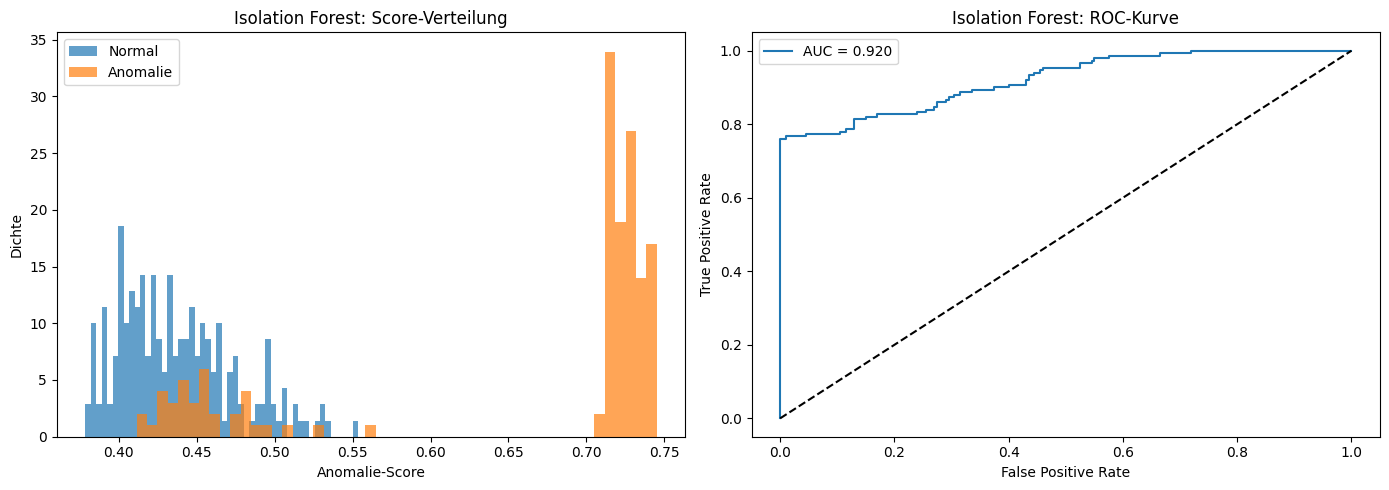

In [8]:
# Visualisierung der Scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Score-Verteilung
axes[0].hist(scores_iso[y_test == 0], bins=50, alpha=0.7, label='Normal', density=True)
axes[0].hist(scores_iso[y_test == 1], bins=50, alpha=0.7, label='Anomalie', density=True)
axes[0].set_xlabel('Anomalie-Score')
axes[0].set_ylabel('Dichte')
axes[0].set_title('Isolation Forest: Score-Verteilung')
axes[0].legend()

# ROC-Kurve
fpr, tpr, thresholds = roc_curve(y_test, scores_iso)
axes[1].plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, scores_iso):.3f}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Isolation Forest: ROC-Kurve')
axes[1].legend()

plt.tight_layout()
plt.savefig('../models/trained/isolation_forest_evaluation.png', dpi=150)
plt.show()

## 3. One-Class SVM

In [9]:
# One-Class SVM Training
print("Training One-Class SVM...")

ocsvm = OneClassSVM(
    kernel='rbf',
    nu=0.1,  # Entspricht contamination
    gamma='scale'
)

ocsvm.fit(X_train_scaled)

# Prediction
y_pred_svm = ocsvm.predict(X_test_scaled)
y_pred_svm = (y_pred_svm == -1).astype(int)

# Scores (Abstand zur Entscheidungsgrenze)
scores_svm = -ocsvm.decision_function(X_test_scaled)

print("\n=== One-Class SVM ===")
print(classification_report(y_test, y_pred_svm, target_names=['Normal', 'Anomalie']))
print(f"ROC-AUC: {roc_auc_score(y_test, scores_svm):.4f}")

Training One-Class SVM...

=== One-Class SVM ===
              precision    recall  f1-score   support

      Normal       1.00      0.86      0.93       200
    Anomalie       0.85      1.00      0.92       150

    accuracy                           0.92       350
   macro avg       0.92      0.93      0.92       350
weighted avg       0.93      0.92      0.92       350

ROC-AUC: 1.0000


## 4. PCA-basierte Anomalie-Erkennung

In [10]:
# PCA Training
print("Training PCA-basierte Anomalie-Erkennung...")

n_components = min(5, X_train_scaled.shape[1])  # Reduziere auf 5 Komponenten
pca = PCA(n_components=n_components)
pca.fit(X_train_scaled)

print(f"Erklärte Varianz: {pca.explained_variance_ratio_.sum()*100:.1f}%")

# Rekonstruktionsfehler als Anomalie-Score
def pca_reconstruction_error(X, pca_model):
    """Berechnet den Rekonstruktionsfehler."""
    X_transformed = pca_model.transform(X)
    X_reconstructed = pca_model.inverse_transform(X_transformed)
    mse = np.mean((X - X_reconstructed)**2, axis=1)
    return mse

# Schwellwert basierend auf Trainingsdaten
train_errors = pca_reconstruction_error(X_train_scaled, pca)
threshold_pca = np.percentile(train_errors, 95)  # 95-Perzentil

# Test
test_errors = pca_reconstruction_error(X_test_scaled, pca)
y_pred_pca = (test_errors > threshold_pca).astype(int)

print(f"\nSchwellwert (95-Perzentil): {threshold_pca:.4f}")
print("\n=== PCA-basiert ===")
print(classification_report(y_test, y_pred_pca, target_names=['Normal', 'Anomalie']))
print(f"ROC-AUC: {roc_auc_score(y_test, test_errors):.4f}")

Training PCA-basierte Anomalie-Erkennung...
Erklärte Varianz: 67.3%

Schwellwert (95-Perzentil): 0.7148

=== PCA-basiert ===
              precision    recall  f1-score   support

      Normal       0.99      0.95      0.97       200
    Anomalie       0.94      0.99      0.96       150

    accuracy                           0.97       350
   macro avg       0.97      0.97      0.97       350
weighted avg       0.97      0.97      0.97       350

ROC-AUC: 0.9990


## 5. Autoencoder (Deep Learning)

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

print(f"TensorFlow Version: {tf.__version__}")

2026-01-18 16:58:40.320699: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-18 16:58:40.390037: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-18 16:58:40.465863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768751920.545676   73369 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768751920.569867   73369 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768751920.750018   73369 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

TensorFlow Version: 2.19.0


In [12]:
def create_autoencoder(input_dim, encoding_dim=5):
    """
    Erstellt einen Autoencoder für Anomalie-Erkennung.
    """
    # Encoder
    inputs = keras.Input(shape=(input_dim,), name='input')
    x = layers.Dense(32, activation='relu', name='enc1')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(16, activation='relu', name='enc2')(x)
    x = layers.BatchNormalization()(x)
    encoded = layers.Dense(encoding_dim, activation='relu', name='bottleneck')(x)
    
    # Decoder
    x = layers.Dense(16, activation='relu', name='dec1')(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(32, activation='relu', name='dec2')(x)
    x = layers.BatchNormalization()(x)
    decoded = layers.Dense(input_dim, activation='linear', name='output')(x)
    
    autoencoder = Model(inputs, decoded, name='autoencoder')
    
    autoencoder.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse'
    )
    
    return autoencoder

# Modell erstellen
input_dim = X_train_scaled.shape[1]
autoencoder = create_autoencoder(input_dim, encoding_dim=5)
autoencoder.summary()

2026-01-18 16:58:44.563069: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc1 (Dense)                    │ (None, 32)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc2 (Dense)                    │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 5)              │            85 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec1 (Dense)                    │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec2 (Dense)                    │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 14)             │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,579 (10.07 KB)

 Trainable params: 2,387 (9.32 KB)

 Non-trainable params: 192 (768.00 B)

In [13]:
# Training
print("Training Autoencoder...")

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = autoencoder.fit(
    X_train_scaled, X_train_scaled,  # Autoencoder: Input = Target
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

Training Autoencoder...
Epoch 1/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 1:03 3s/step - loss: 2.2932

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.8273 - val_loss: 0.9938


Epoch 2/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.4965

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2729 - val_loss: 0.9828


Epoch 3/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0724

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0232 - val_loss: 0.9680


Epoch 4/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0195

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9078 - val_loss: 0.9470


Epoch 5/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0524

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8428 - val_loss: 0.9208


Epoch 6/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7630

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7994 - val_loss: 0.8917


Epoch 7/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7736

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7793 - val_loss: 0.8589


Epoch 8/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7179

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7499 - val_loss: 0.8269


Epoch 9/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7644

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7268 - val_loss: 0.8012


Epoch 10/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7759

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7182 - val_loss: 0.7719


Epoch 11/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7136

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7005 - val_loss: 0.7528


Epoch 12/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8363

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6909 - val_loss: 0.7301


Epoch 13/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7397

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6764 - val_loss: 0.7147


Epoch 14/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7226

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6656 - val_loss: 0.7012


Epoch 15/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7441

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6578 - val_loss: 0.6932


Epoch 16/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7703

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6498 - val_loss: 0.6823


Epoch 17/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6271

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6409 - val_loss: 0.6743


Epoch 18/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6683

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6327 - val_loss: 0.6678


Epoch 19/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5892

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6312 - val_loss: 0.6638


Epoch 20/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5958

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6316 - val_loss: 0.6599


Epoch 21/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6400

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6290 - val_loss: 0.6560


Epoch 22/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5137

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6149 - val_loss: 0.6486


Epoch 23/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6457

18/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6159 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6089 - val_loss: 0.6443


Epoch 24/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5780

21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5802 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5970 - val_loss: 0.6425


Epoch 25/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5671

19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5877 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5962 - val_loss: 0.6376


Epoch 26/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5466

13/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5621 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5895 - val_loss: 0.6327


Epoch 27/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 0.5398

20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5879  

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5806 - val_loss: 0.6226


Epoch 28/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6220

18/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6034 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5899 - val_loss: 0.6154


Epoch 29/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6291

21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5869 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5784 - val_loss: 0.6137


Epoch 30/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5697

22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5669 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5715 - val_loss: 0.6138


Epoch 31/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6354

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5678 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5752 - val_loss: 0.6028


Epoch 32/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4805

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5575 - val_loss: 0.6000


Epoch 33/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5130

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5597 - val_loss: 0.5949


Epoch 34/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6085

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5545 - val_loss: 0.5892


Epoch 35/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4791

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5528 - val_loss: 0.5865


Epoch 36/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5004

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5515 - val_loss: 0.5821


Epoch 37/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5591

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5450 - val_loss: 0.5807


Epoch 38/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5022

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5426 - val_loss: 0.5762


Epoch 39/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5737

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5404 - val_loss: 0.5742


Epoch 40/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4822

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5316 - val_loss: 0.5700


Epoch 41/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5290

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5300 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5349 - val_loss: 0.5664


Epoch 42/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4921

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5288 - val_loss: 0.5635


Epoch 43/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5341

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5216 - val_loss: 0.5590


Epoch 44/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4983

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5248 - val_loss: 0.5556


Epoch 45/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4417

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5134 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5260 - val_loss: 0.5546


Epoch 46/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4453

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5072 - val_loss: 0.5533


Epoch 47/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4675

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5134 - val_loss: 0.5490


Epoch 48/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4914

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5138 - val_loss: 0.5473


Epoch 49/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4544

22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5072 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5085 - val_loss: 0.5441


Epoch 50/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5679

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5028 - val_loss: 0.5440


Epoch 51/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4609

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5017 - val_loss: 0.5378


Epoch 52/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4839

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4970 - val_loss: 0.5365


Epoch 53/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4838

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4935 - val_loss: 0.5356


Epoch 54/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4630

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5011 - val_loss: 0.5315


Epoch 55/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4965

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4948 - val_loss: 0.5285


Epoch 56/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4772

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4875 - val_loss: 0.5309


Epoch 57/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4981

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4911 - val_loss: 0.5259


Epoch 58/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4878

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4856 - val_loss: 0.5299


Epoch 59/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4739

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4850 - val_loss: 0.5203


Epoch 60/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4402

22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4666 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4738 - val_loss: 0.5179


Epoch 61/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4026

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4797 - val_loss: 0.5148


Epoch 62/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5593

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4784 - val_loss: 0.5161


Epoch 63/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4824

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4810 - val_loss: 0.5106


Epoch 64/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5443

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4719 - val_loss: 0.5092


Epoch 65/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5744

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4744 - val_loss: 0.5054


Epoch 66/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4503

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4697 - val_loss: 0.5034


Epoch 67/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4215

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4676 - val_loss: 0.4970


Epoch 68/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4517

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4648 - val_loss: 0.4947


Epoch 69/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4241

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4571 - val_loss: 0.4889


Epoch 70/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4150

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4375 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4479 - val_loss: 0.4902


Epoch 71/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4657

20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4453 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4497 - val_loss: 0.4914


Epoch 72/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4534

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4479 - val_loss: 0.4879


Epoch 73/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4596

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4413 - val_loss: 0.4861


Epoch 74/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4180

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4401 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4467 - val_loss: 0.4803


Epoch 75/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3993

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4418 - val_loss: 0.4772


Epoch 76/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5063

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4490 - val_loss: 0.4778


Epoch 77/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4951

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4463 - val_loss: 0.4751


Epoch 78/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4280

21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4508 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4342 - val_loss: 0.4676


Epoch 79/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3622

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4174 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4287 - val_loss: 0.4629


Epoch 80/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4458

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4290 - val_loss: 0.4633


Epoch 81/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4813

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4312 - val_loss: 0.4590


Epoch 82/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3948

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4294 - val_loss: 0.4576


Epoch 83/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4048

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4160 - val_loss: 0.4579


Epoch 84/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4079

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4171 - val_loss: 0.4536


Epoch 85/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4024

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4224 - val_loss: 0.4524


Epoch 86/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4615

22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4204 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4199 - val_loss: 0.4481


Epoch 87/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3951

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4139 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4191 - val_loss: 0.4482


Epoch 88/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3974

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4140 - val_loss: 0.4421


Epoch 89/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4395

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4105 - val_loss: 0.4429


Epoch 90/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4561

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4071 - val_loss: 0.4365


Epoch 91/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4084

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4168 - val_loss: 0.4369


Epoch 92/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3630

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4089 - val_loss: 0.4349


Epoch 93/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4297

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4053 - val_loss: 0.4316


Epoch 94/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3935

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4085 - val_loss: 0.4274


Epoch 95/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3814

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3973 - val_loss: 0.4273


Epoch 96/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3745

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4017 - val_loss: 0.4313


Epoch 97/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3981

21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3993 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4083 - val_loss: 0.4265


Epoch 98/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4418

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3946 - val_loss: 0.4244


Epoch 99/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3742

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3933 - val_loss: 0.4230


Epoch 100/100


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3976

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3943 - val_loss: 0.4177


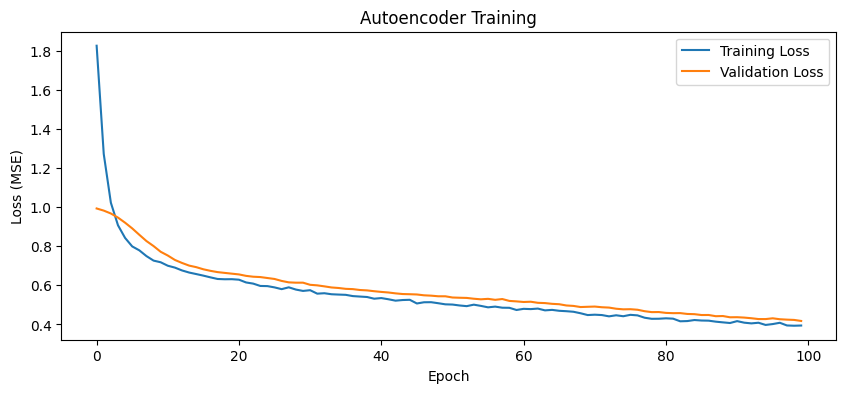

In [14]:
# Training Loss visualisieren
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Autoencoder Training')
plt.legend()
plt.savefig('../models/trained/autoencoder_training.png', dpi=150)
plt.show()

In [15]:
# Autoencoder Evaluation
def autoencoder_reconstruction_error(X, model):
    """Berechnet den Rekonstruktionsfehler."""
    X_reconstructed = model.predict(X, verbose=0)
    mse = np.mean((X - X_reconstructed)**2, axis=1)
    return mse

# Schwellwert aus Trainingsdaten
train_errors_ae = autoencoder_reconstruction_error(X_train_scaled, autoencoder)
threshold_ae = np.percentile(train_errors_ae, 95)

# Test
test_errors_ae = autoencoder_reconstruction_error(X_test_scaled, autoencoder)
y_pred_ae = (test_errors_ae > threshold_ae).astype(int)

print(f"Schwellwert (95-Perzentil): {threshold_ae:.6f}")
print("\n=== Autoencoder ===")
print(classification_report(y_test, y_pred_ae, target_names=['Normal', 'Anomalie']))
print(f"ROC-AUC: {roc_auc_score(y_test, test_errors_ae):.4f}")

Schwellwert (95-Perzentil): 0.779147

=== Autoencoder ===
              precision    recall  f1-score   support

      Normal       1.00      0.92      0.96       200
    Anomalie       0.90      1.00      0.95       150

    accuracy                           0.95       350
   macro avg       0.95      0.96      0.95       350
weighted avg       0.96      0.95      0.95       350

ROC-AUC: 1.0000


## 6. Modellvergleich

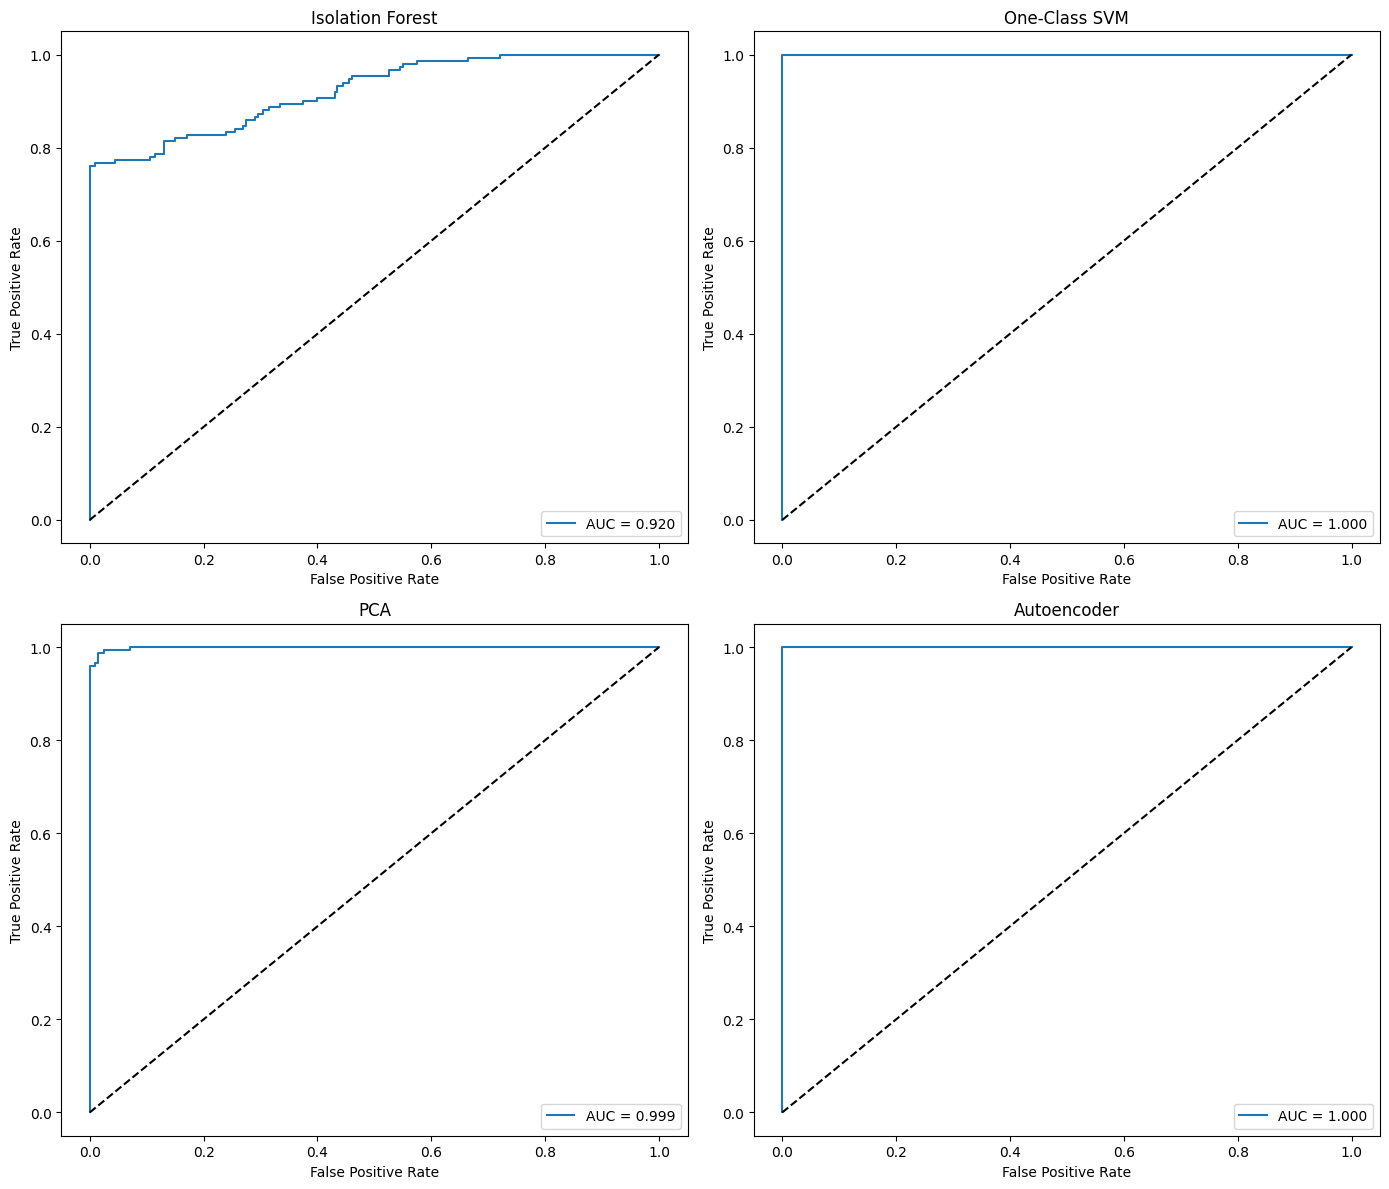

In [16]:
# Vergleich aller Modelle
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

models = [
    ('Isolation Forest', scores_iso, y_pred_iso),
    ('One-Class SVM', scores_svm, y_pred_svm),
    ('PCA', test_errors, y_pred_pca),
    ('Autoencoder', test_errors_ae, y_pred_ae)
]

for ax, (name, scores, y_pred) in zip(axes.flat, models):
    # ROC-Kurve
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc = roc_auc_score(y_test, scores)
    
    ax.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{name}')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('../models/trained/model_comparison_roc.png', dpi=150)
plt.show()

In [17]:
# Zusammenfassung
print("=" * 60)
print("MODELLVERGLEICH - Anomalie-Erkennung")
print("=" * 60)

from sklearn.metrics import precision_score, recall_score, f1_score

results = []
for name, scores, y_pred in models:
    results.append({
        'Modell': name,
        'ROC-AUC': roc_auc_score(y_test, scores),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    })

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

MODELLVERGLEICH - Anomalie-Erkennung
          Modell  ROC-AUC  Precision   Recall  F1-Score
Isolation Forest   0.9204   0.825175 0.786667  0.805461
   One-Class SVM   1.0000   0.847458 1.000000  0.917431
             PCA   0.9990   0.937107 0.993333  0.964401
     Autoencoder   1.0000   0.903614 1.000000  0.949367


## 7. Modelle speichern

In [18]:
import joblib

MODEL_DIR = '../models/trained'

# Scaler speichern (wichtig für Inference!)
joblib.dump(scaler, f'{MODEL_DIR}/scaler.joblib')
print("✓ Scaler gespeichert")

# Isolation Forest
joblib.dump(iso_forest, f'{MODEL_DIR}/isolation_forest.joblib')
print("✓ Isolation Forest gespeichert")

# One-Class SVM
joblib.dump(ocsvm, f'{MODEL_DIR}/one_class_svm.joblib')
print("✓ One-Class SVM gespeichert")

# PCA
joblib.dump({'pca': pca, 'threshold': threshold_pca}, f'{MODEL_DIR}/pca_anomaly.joblib')
print("✓ PCA gespeichert")

# Autoencoder (Keras)
autoencoder.save(f'{MODEL_DIR}/autoencoder.keras')
print("✓ Autoencoder gespeichert")

# Metadata
metadata = {
    'feature_names': feature_cols,
    'n_features': len(feature_cols),
    'autoencoder_threshold': float(threshold_ae),
    'pca_threshold': float(threshold_pca),
    'scaler_mean': scaler.mean_.tolist(),
    'scaler_scale': scaler.scale_.tolist()
}

import json
with open(f'{MODEL_DIR}/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✓ Metadata gespeichert")

✓ Scaler gespeichert
✓ Isolation Forest gespeichert
✓ One-Class SVM gespeichert
✓ PCA gespeichert


✓ Autoencoder gespeichert
✓ Metadata gespeichert


In [19]:
# ONNX Export für Isolation Forest
try:
    from skl2onnx import convert_sklearn
    from skl2onnx.common.data_types import FloatTensorType
    
    # Input-Typ definieren
    initial_type = [('input', FloatTensorType([None, len(feature_cols)]))]
    
    # Konvertieren
    onnx_model = convert_sklearn(iso_forest, initial_types=initial_type)
    
    # Speichern
    with open(f'{MODEL_DIR}/isolation_forest.onnx', 'wb') as f:
        f.write(onnx_model.SerializeToString())
    
    print("✓ Isolation Forest als ONNX exportiert")
except ImportError:
    print("⚠ skl2onnx nicht installiert. ONNX-Export übersprungen.")
    print("  Installiere mit: pip install skl2onnx")

⚠ skl2onnx nicht installiert. ONNX-Export übersprungen.
  Installiere mit: pip install skl2onnx


In [20]:
# TensorFlow.js Export für Autoencoder
try:
    import tensorflowjs as tfjs
    
    tfjs.converters.save_keras_model(autoencoder, f'{MODEL_DIR}/autoencoder_tfjs')
    print("✓ Autoencoder als TensorFlow.js exportiert")
except ImportError:
    print("⚠ tensorflowjs nicht installiert. TF.js-Export übersprungen.")
    print("  Installiere mit: pip install tensorflowjs")

failed to lookup keras version from the file,
    this is likely a weight only file
✓ Autoencoder als TensorFlow.js exportiert


## 8. Beispiel: Inference mit gespeichertem Modell

In [21]:
# Beispiel: Wie man die Modelle in Produktion verwendet

def predict_anomaly(features_dict, model_type='isolation_forest'):
    """
    Beispiel-Funktion für Anomalie-Erkennung.
    
    Parameters:
    -----------
    features_dict : dict
        Dictionary mit Feature-Namen und Werten
    model_type : str
        'isolation_forest', 'autoencoder', oder 'pca'
    
    Returns:
    --------
    dict mit is_anomaly, score, threshold
    """
    # Features in richtige Reihenfolge bringen
    X = np.array([[features_dict.get(f, 0) for f in feature_cols]])
    
    # Skalieren
    X_scaled = scaler.transform(X)
    
    if model_type == 'isolation_forest':
        score = -iso_forest.score_samples(X_scaled)[0]
        # Dynamischer Threshold basierend auf Training
        threshold = 0.5  # Anpassen basierend auf Validierung
        is_anomaly = iso_forest.predict(X_scaled)[0] == -1
        
    elif model_type == 'autoencoder':
        reconstructed = autoencoder.predict(X_scaled, verbose=0)
        score = float(np.mean((X_scaled - reconstructed)**2))
        threshold = threshold_ae
        is_anomaly = score > threshold
        
    elif model_type == 'pca':
        X_transformed = pca.transform(X_scaled)
        X_reconstructed = pca.inverse_transform(X_transformed)
        score = float(np.mean((X_scaled - X_reconstructed)**2))
        threshold = threshold_pca
        is_anomaly = score > threshold
    
    return {
        'is_anomaly': bool(is_anomaly),
        'score': float(score),
        'threshold': float(threshold),
        'model': model_type
    }

# Test mit einem Sample
test_sample = dict(zip(feature_cols, X_test[0]))
print("Test-Sample (erstes aus Testset):")
print(f"  Tatsächlich: {'Anomalie' if y_test[0] == 1 else 'Normal'}")
print()

for model in ['isolation_forest', 'autoencoder', 'pca']:
    result = predict_anomaly(test_sample, model)
    print(f"{model}: {result}")

Test-Sample (erstes aus Testset):
  Tatsächlich: Normal

isolation_forest: {'is_anomaly': False, 'score': 0.44295415001850885, 'threshold': 0.5, 'model': 'isolation_forest'}
autoencoder: {'is_anomaly': False, 'score': 0.5746493931734021, 'threshold': 0.7791466079353253, 'model': 'autoencoder'}
pca: {'is_anomaly': False, 'score': 0.36026157972596046, 'threshold': 0.7148225816035503, 'model': 'pca'}


## Zusammenfassung

### Trainierte Modelle

| Modell | Datei | Format | Verwendung |
|--------|-------|--------|------------|
| Isolation Forest | `isolation_forest.joblib` | scikit-learn | Python |
| Isolation Forest | `isolation_forest.onnx` | ONNX | Node-RED ML Inference |
| One-Class SVM | `one_class_svm.joblib` | scikit-learn | Python |
| PCA | `pca_anomaly.joblib` | scikit-learn | Python |
| Autoencoder | `autoencoder.keras` | Keras | Python |
| Autoencoder | `autoencoder_tfjs/` | TensorFlow.js | Node-RED ML Inference |

### Nächste Schritte

- **03_rul_prediction.ipynb** - RUL-Modelle trainieren
- **05_model_export.ipynb** - Detaillierter Export für Node-RED